In [230]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [231]:
# include("random_linear.jl")
# A, B = gendiscrete(4, 3)

In [271]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat) 
    H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c*ρ
    # display(∇projection(λhat)')
    # H = zeros(p.ncu_cone,p.ncu_cone)
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # keep track of trajectories for each iterate
    Xh=[deepcopy(X) for i = 1:1000]

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    Xh[1] .= X

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:5
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        Xh[iter + 1] .= X  
        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
                
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + ρ*Uc/cone_scale)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        if verbose
            @show convio
        end
        if convio <1e-4  # if terminal condition with contraint violation
            # @info "success!"
            return Xh[1:(iter + 1)];
        end

        ρ *= ϕ  # update penalty
    end
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [233]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end

∇projection (generic function with 1 method)

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   5.63e+04   0.00e+00  0.0000    1.00e-08    1.00e+00
convio = 32.53060472971621
  2    0.000e+00   7.85e+04   0.00e+00  0.0000    1.00e-08    1.00e+01
convio = 18.95914810353352
  3    0.000e+00   1.25e+05   0.00e+00  0.0000    1.00e-08    1.00e+02
convio = 9.712227479108025
  4    0.000e+00   1.30e+05   0.00e+00  0.0000    1.00e-08    1.00e+03
convio = 2.00495694601
  5    0.000e+00   1.30e+05   0.00e+00  0.0000    1.00e-08    1.00e+04
convio = 0.22603557070078995
  6    0.000e+00   1.53e+05   0.00e+00  0.0000    1.00e-08    1.00e+05
convio = 0.022897274202238083
  7    0.000e+00   3.74e+05   0.00e+00  0.0000    1.00e-08    1.00e+06
convio = 0.0022927087475785313
  8    0.000e+00   2.55e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
convio = 0.00022930073286048236
  9    0.000e+00   2.43e+07   0.00e+00  0.0000    1.00e-08    1.00e+08

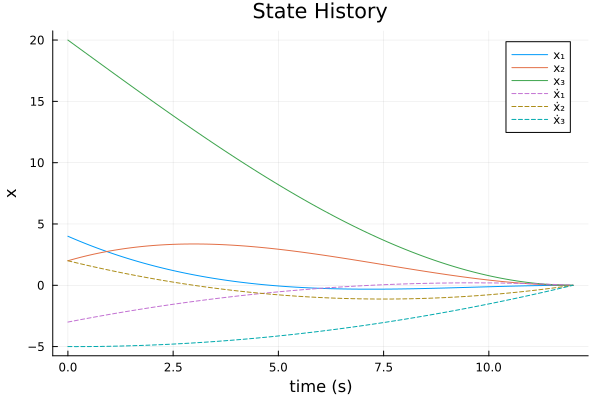

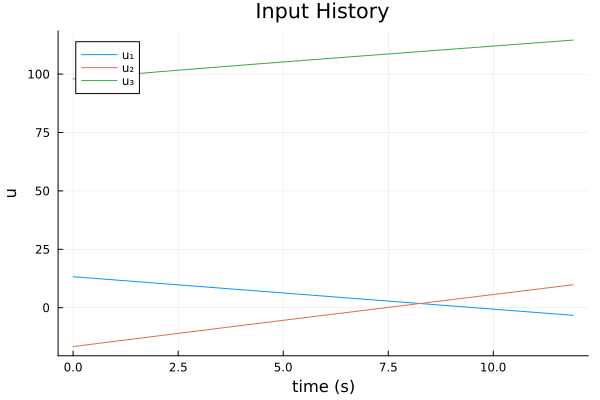

In [450]:
# Let's solve

nx = 6
nu = 3
N = 121
dt = 0.1
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-2*Diagonal([1,1,1,1.0,1,1])
R = 1e-1*Diagonal([1,1,1])
Qf = 1000*Q

# ground_level = 0.0
gravity = [0; 0; 9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 10.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*0; 
cone_scale = 28  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [mass * gravity for k = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
Xhist = mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 10,verbose = true,ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation
- Scaling between conic constraints and other ones
- Solution polishing

In [451]:
# Check conic violation
convio = 0.0
for k = 1:N-1
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

4.025509249696679

3.7338479609709125

3.4423630437968242

3.151058275749559

2.859937397687652

2.5690041214493498

2.278262138009868

1.9877151261420565

1.69736676162778

1.4072207270721826

1.1172807223789292

0.8275504759506944

0.5380337566866942

0.24873438685688498

-0.04034374405797436

-0.3291966644612927

-0.6178203045590784

-0.9062104789776306

-1.1943628679405052

-1.482272996847776

-1.7699362140807686

-2.0573476668329587

-2.3445022747418314

-2.631394701067027

-2.918019321125973

-3.20437018765908

-3.4904409927515054

-3.7762250258859815

-4.061715127641051

-4.346903638478381

-4.631782341981271

-4.916342401810875

-5.20057429153503

-5.484467716353683

-5.7680115255910955

-6.051193614643653

-6.3340008148579265

-6.616418769559729

-6.898431794153712

-7.180022717853436

-7.461172704172924

-7.74186104679627

-8.022064936823764

-8.301759196647357

-8.580915974807533

-8.859504395089495

-9.137490151786684

-9.414835041435087

-9.691496419333312

-9.967426566721084

-10.242571951480365

-10.51687236150796

-10.790259885307012

-11.06265770863456

-11.333978688942

-11.604123660506051

-11.872979412138095

-12.140416265656505

-12.406285166284615

-12.67041417508658

-12.932604227707127

-13.192623992326403

-13.450203622416094

-13.705027156800423

-13.956723272329853

-14.204854047625416

-14.44890135950193

-14.6882505256745

-14.922170862608315

-15.149793005381158

-15.370083234410895

-15.581815819745781

-15.7835457291381

-15.973586175393805

-16.149998531152352

-16.310605875316604

-16.45304476607901

-16.57487028957596

-16.67372319695911

-16.747551646715756

-16.79485498904557

-16.814893312302495

-16.807800977119744

-16.774566207124973

-16.716883731002223

-16.63692837300646

-16.537112606599216

-16.419878538052092

-16.287549059489265

-16.142239772286985

-15.98582009169812

-15.819908090839235

-15.64588529002657

-15.464921238602493

-15.278001341506549

-15.08595416994654

-14.889476373495542

-14.689154457378683

-14.485483328629352

-14.278881835555868

-14.06970565875092

-13.858257943560147

-13.644798044532154

-13.429548710944438

-13.21270199466855

-12.994424115205298

-12.774859475127199

-12.554133983521368

-12.332357815282503

-12.10962770969157

-11.886028891883608

-11.66163668479852

-11.436517866330881

-11.210731816052377

-10.984331487578759

-10.757364235980495

-10.529872524270292

-10.301894528672296

-10.073464658882186

-9.844614006627982

In [498]:
### MPC style ###
Nsim = 121
Nh = 30
t_vec = dt*(0:Nsim-1)

# x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [5, 3, 21, -3, 2, -5.0]

xg = [0,0,0,0,0,0.0]
Q = 10e-1*Diagonal([1,1,1,1.0,1,1])  # make this higher!
R = 1e-1*Diagonal([1,1,1])
Qf = 1000*Q  # change this!
θ_thrust_max = 12.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    X[1] .= Xhist[i]  # update initial
    X_ = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 10,verbose = false,ρ = 1e0, ϕ = 10.0);
    Uhist[i] = Un[1]
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

In [499]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

-1.0108488344164073

-1.6093237457262823

-2.1086268382548745

-2.5209043597372407

-2.8583983440868934

-3.13299956978085

-3.355898270273155

-3.5373454965909907

-3.6865191187019164

-3.811476928484911

-3.9191748547812324

-4.015528910786713

-4.105502864649836

-4.193207939132048

-4.2820049853404285

-4.374603010640186

-4.473150533383215

-4.579318055404382

-4.694371137445394

-4.819234294064163

-4.9545463334586906

-5.10070796329256

-5.257922545456665

-5.426230865512995

-5.605540722522193

-5.79565206502388

-5.996278313050436

-6.207064422209889

-6.427602168269482

-6.657443061179645

-6.896109236575084

-7.143102620188099

-7.397912615621793

-7.66002252770722

-7.928914901325845

-8.204075928273598

-8.484999051710085

-8.771187878292992

-9.062158491660536

-9.357441246982942

-9.656582114432709

-9.959143629256028

-10.264705497354905

-10.57286489764722

-10.883236515735986

-11.19545233738572

-11.50916122480321

-11.824028293583982

-12.139734103266028

-12.455973669573009

-12.772455301476022

-13.088899260985956

-13.405036237919303

-13.720605625539287

-14.035353575706292

-14.349030803663524

-14.661390102463544

-14.972183514855473

-15.28115909565162

-15.588057179540385

-15.892606047261532

-16.19451685622763

-16.493477669289643

-16.789146376880346

-17.081142263307456

-17.369035918942295

-17.652337150542273

-17.930480500976646

-18.20280797499771

-18.4685486121807

-18.726794708882807

-18.97647486237556

-19.216324737924136

-19.44485774770712

-19.660339919000773

-19.860776293808254

-20.043920102486766

-20.207319762444747

-20.34842015750191

-20.464729771084293

-20.554050026609342

-20.6147374544059

-20.645941836308882

-20.64775186981718

-20.621199176478434

-20.568117806076277

-20.490904707154264

-20.392250073527165

-20.274897833778265

-20.141469335134477

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

-20.85179869982917

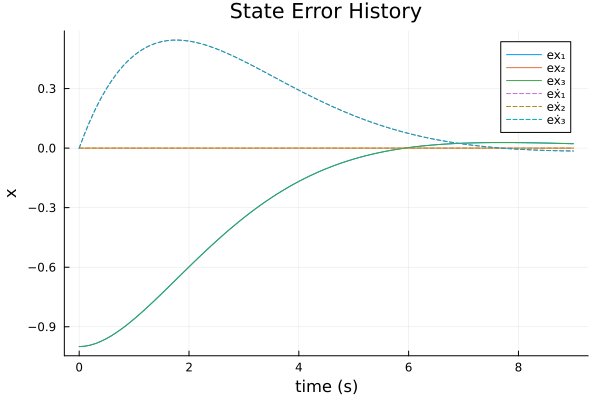

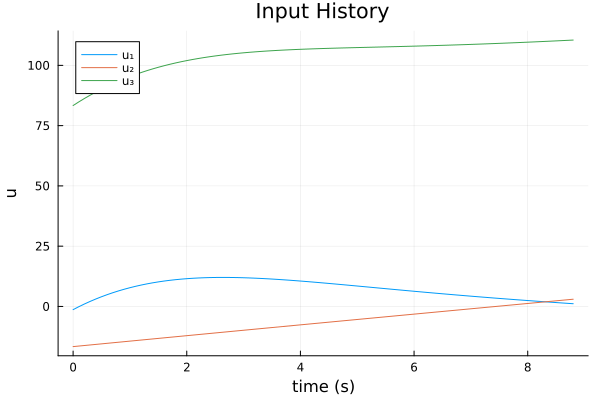

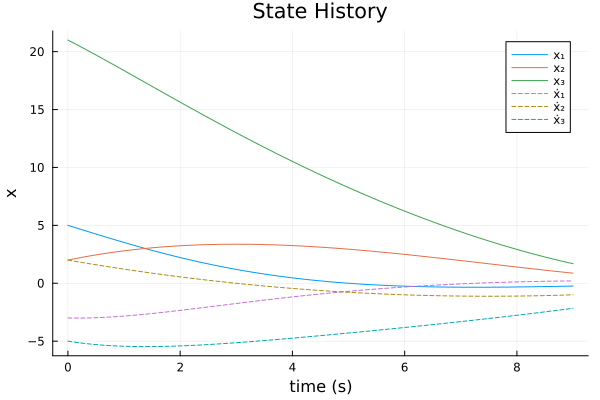

In [500]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))